In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pyspark import SparkContext, SparkConf
from hdfs import InsecureClient
from pyspark.sql import SparkSession

Using TensorFlow backend.


In [3]:
sparkSession = SparkSession.builder.appName("example-pyspark-read-and-write").getOrCreate()
df_load = sparkSession.read.csv("hdfs://localhost:9000/arun/Google_Stock_Price_Train.csv")
df_load.show()

+---------+------+------+------+------+----------+
|      _c0|   _c1|   _c2|   _c3|   _c4|       _c5|
+---------+------+------+------+------+----------+
|     Date|  Open|  High|   Low| Close|    Volume|
| 1/3/2012|325.25|332.83|324.97|663.59| 7,380,500|
| 1/4/2012|331.27|333.87|329.08|666.45| 5,749,400|
| 1/5/2012|329.83|330.75|326.89|657.21| 6,590,300|
| 1/6/2012|328.34|328.77|323.68|648.24| 5,405,900|
| 1/9/2012|322.04|322.29|309.46|620.76|11,688,800|
|1/10/2012| 313.7|315.72| 307.3|621.43| 8,824,000|
|1/11/2012|310.59|313.52| 309.4|624.25| 4,817,800|
|1/12/2012|314.43|315.26|312.08|627.92| 3,764,400|
|1/13/2012|311.96| 312.3|309.37|623.28| 4,631,800|
|1/17/2012|314.81|314.81|311.67|626.86| 3,832,800|
|1/18/2012|312.14|315.82| 309.9|631.18| 5,544,000|
|1/19/2012| 319.3| 319.3|314.55|637.82|12,657,800|
|1/20/2012|294.16| 294.4|289.76|584.39|21,231,800|
|1/23/2012|291.91|293.23|290.49|583.92| 6,851,300|
|1/24/2012|292.07|292.74|287.92|579.34| 6,134,400|
|1/25/2012|287.68|288.27|282.13

In [7]:
train = df_load.toPandas()
train.head()

,_c0,_c1,_c2,_c3,_c4,_c5
0,Date,Open,High,Low,Close,Volume
1,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
2,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
3,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
4,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"


In [8]:
training_set=train.iloc[1:len(train),1:2].values

In [9]:
training_set

array([[u'325.25'],
       [u'331.27'],
       [u'329.83'],
       ...,
       [u'793.7'],
       [u'783.33'],
       [u'782.75']], dtype=object)

In [10]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

/home/gayatri/anaconda/envs/arunenv/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
training_set_scaled.shape

(1258, 1)

In [12]:
X_train=[]
y_train=[]
for i in range(60,1258):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1198, 60, 1)

In [14]:
regressor=Sequential()

In [15]:
regressor.add(LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.4))

In [16]:
regressor.add(LSTM(units=100,return_sequences=True))
regressor.add(Dropout(0.6))

In [17]:
regressor.add(LSTM(units=100,return_sequences=True))
regressor.add(Dropout(0.6))

In [18]:
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.4))

In [19]:
regressor.add(Dense(units=1))

In [20]:
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [21]:
#X_train.shape
regressor.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0367
Epoch 2/10
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0085
Epoch 3/10
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0067
Epoch 4/10
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0083
Epoch 5/10
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0063
Epoch 6/10
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0059
Epoch 7/10
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0053
Epoch 8/10
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0049
Epoch 9/10
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0053
Epoch 10/10
1198/1198 [==============================] - 19s 15ms/step - loss: 0.0047


In [22]:
df_load_test = sparkSession.read.csv("hdfs://localhost:9000/arun/Google_Stock_Price_Test.csv")
test = df_load_test.toPandas()

In [40]:
real_stock_price = test.iloc[1:len(test), 1:2].values
train_1 = train.iloc[1:len(train), 1:2]
test_1 = test.iloc[1:len(test), 1:2]
total_data=pd.concat([train_1['_c1'],test_1['_c1']],axis=0)

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [29]:
inputs=total_data[len(train)-len(test)-60:].values
inputs=inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [31]:
X_test=[]
for i in range(60,80):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)
X_test.shape
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [33]:
predicted_stock_price=regressor.predict(X_test)
predicted_stock_price=sc.inverse_transform(predicted_stock_price)

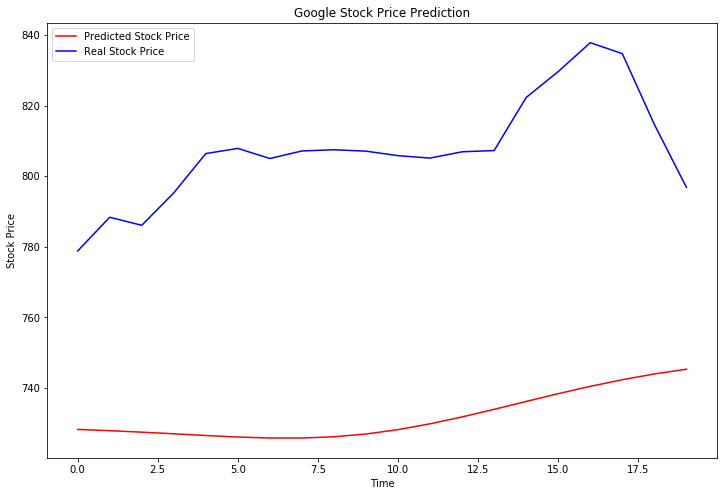

In [42]:
#Visualization
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(predicted_stock_price,color='red',label='Predicted Stock Price')
plt.plot(real_stock_price.astype(float),color='blue',label='Real Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [43]:
from pyspark.ml import Pipeline